# Introduction

The purpose of this notebook is to download data and process it. As a result we will get a dataset ready for further analyses and modeling.

In [1]:
import matplotlib

# let matplotlib plots be part of Jupyter Notebook
%matplotlib inline

# set up higher resolution for matplotlib plots
%config InlineBackend.figure_format = 'retina'

# Data loading and processing pipeline

In [2]:
# Change folder
%cd ../src

/Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/src


In [3]:
# execute tests to make sure everything is working as expected
! python -m pytest

============================= test session starts ==============================
platform darwin -- Python 3.6.8, pytest-5.2.2, py-1.8.0, pluggy-0.13.0
rootdir: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski, inifile: tox.ini
collected 10 items                                                             

tests/cleaning/test_pipeline.py ..                                       [ 20%]
tests/cleaning/test_remove_same_location.py ...                          [ 50%]
tests/features/test_holidays.py ...                                      [ 80%]
tests/features/test_season.py ..                                         [100%]

============================== 10 passed in 0.81s ==============================


In [4]:
# run data loading and processing pipeline (without removing any record so that we can inspect everything)
!python run_pipeline.py --remove=0

Pipeline execution started
Root folder set to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals
* SameLocationRemover *
--> input data shape:  (457015, 10)
--> output data shape:  (457015, 11)
* SeasonFeature *
--> input data shape:  (457015, 11)
--> output data shape:  (457015, 12)
* HolidaysFeature *
--> input data shape:  (457015, 12)
--> output data shape:  (457015, 13)
Data saved to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/data/processed/bike_rentals.csv
Pipeline execution completed


# Visual inspection

In [5]:
import os
import pandas as pd

filepath = os.path.join(os.getcwd(), '..', 'data', 'processed', 'bike_rentals.csv')
bike_rentals_df = pd.read_csv(filepath)

In [6]:
bike_rentals_df['Rental datetime'] = pd.to_datetime(bike_rentals_df['Rental datetime'])
bike_rentals_df['Return datetime'] = pd.to_datetime(bike_rentals_df['Return datetime'])
bike_rentals_df['Duration'] = pd.to_timedelta(bike_rentals_df['Duration'])

In [7]:
bike_rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457015 entries, 0 to 457014
Data columns (total 13 columns):
Bike number                 457015 non-null int64
Rental datetime             457015 non-null datetime64[ns]
Return datetime             457015 non-null datetime64[ns]
Rental station              457015 non-null object
Return station              457015 non-null object
Duration                    457015 non-null timedelta64[ns]
Rental station latitude     397915 non-null float64
Rental station longitude    397915 non-null float64
Return station latitude     400873 non-null float64
Return station longitude    400873 non-null float64
IsDeleted                   457015 non-null bool
Season                      457015 non-null int64
Holidays                    457015 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(4), int64(2), object(2), timedelta64[ns](1)
memory usage: 39.2+ MB


In [8]:
bike_rentals_df.head()

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
0,57719,2019-06-26 00:00:10,2019-06-26 00:06:19,Skarbowców / Wietrzna,Krzycka / Aleja Karkonoska (Park Południowy),00:06:09,51.073290,16.994850,51.074992,17.007058,False,3,False
1,650480,2019-06-26 00:00:13,2019-06-26 00:06:59,Rynek,Plac Legionów,00:06:46,51.109782,17.030175,51.104413,17.022536,False,3,False
2,650988,2019-06-26 00:00:15,2019-06-26 00:13:32,Poza oficjalną stacją,Wałbrzyska - pętla tramwajowa,00:13:17,NaN,NaN,51.065777,16.988575,False,3,False
3,57603,2019-06-26 00:00:21,2019-06-26 00:23:53,Plac Uniwersytecki (UWr),Legnicka / Wejherowska,00:23:32,51.113871,17.034484,51.125276,16.984447,False,3,False
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False


In [9]:
bike_rentals_df.tail()

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
457010,650339,2019-10-29 23:50:00,2019-10-29 23:51:00,Szewska / Kazimierza Wielkiego,Szewska / Kazimierza Wielkiego,00:01:00,NaN,NaN,NaN,NaN,True,4,False
457011,650013,2019-10-29 23:51:00,2019-10-29 23:51:00,Kołłątaja / Podwale,Kołłątaja / Podwale,00:00:00,51.103854,17.036780,51.103854,17.036780,True,4,False
457012,57550,2019-10-29 23:53:00,2019-10-29 23:54:00,Rondo Reagana,Rondo Reagana,00:01:00,51.112154,17.060451,51.112154,17.060451,True,4,False
457013,57948,2019-10-29 23:54:00,2019-10-29 23:56:00,Zaporoska / Gajowicka,Zaporoska / Wielka / Krucza,00:02:00,51.097209,17.013967,51.094310,17.014790,False,4,False
457014,57550,2019-10-29 23:56:00,2019-10-29 23:57:00,Rondo Reagana,Rondo Reagana,00:01:00,51.112154,17.060451,51.112154,17.060451,True,4,False


## Rentals returned to the same bike station

In [10]:
idx = bike_rentals_df['Rental station'] == bike_rentals_df['Return station']
print(f"Number of records: {bike_rentals_df.loc[idx, :].shape[0]}")

Number of records: 76852


In [11]:
total_seconds = bike_rentals_df.loc[idx, 'Duration'].dt.total_seconds();

print(f"Min: {total_seconds.min()}, Max: {total_seconds.max()}")
print(f"Avg: {total_seconds.mean()}, Std: {total_seconds.std()}")

Min: 0.0, Max: 56135.0
Avg: 520.872091812835, Std: 1387.2647139280132


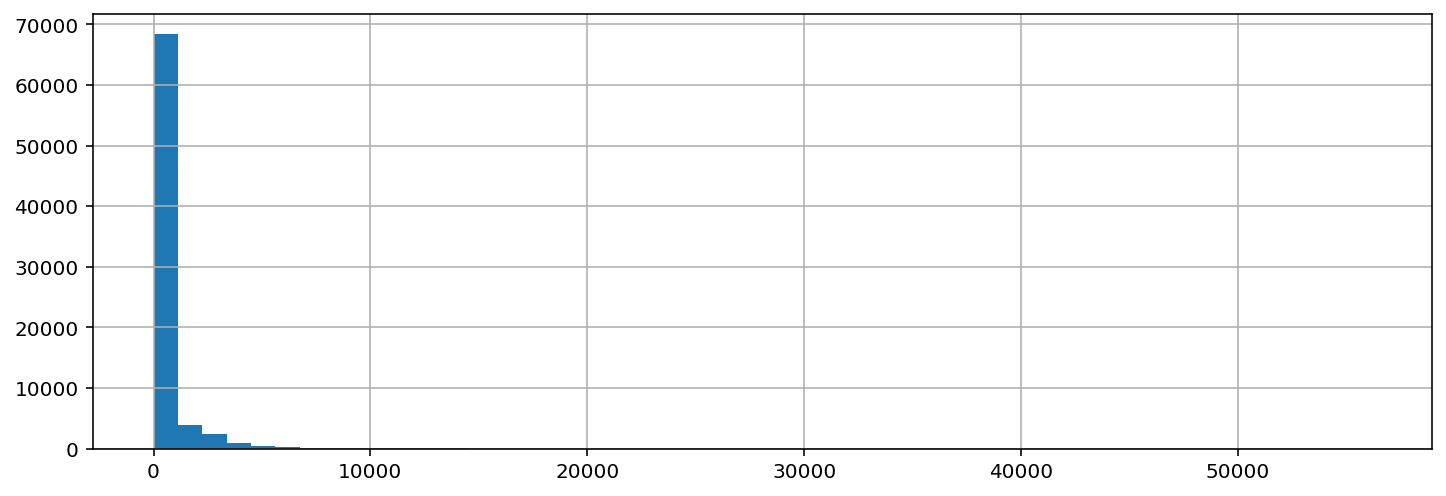

In [12]:
total_seconds.hist(bins=50, figsize=(12, 4));

In [13]:
idx = (bike_rentals_df['Rental station'] == 'Poza oficjalną stacją') & \
      (bike_rentals_df['Return station'] == 'Poza oficjalną stacją')
bike_rentals_df.loc[idx, :]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
16,57623,2019-06-26 00:02:30,2019-06-26 00:06:15,Poza oficjalną stacją,Poza oficjalną stacją,00:03:45,NaN,NaN,NaN,NaN,True,3,False
137,57353,2019-06-26 00:23:12,2019-06-26 00:26:04,Poza oficjalną stacją,Poza oficjalną stacją,00:02:52,NaN,NaN,NaN,NaN,True,3,False
154,57353,2019-06-26 00:27:35,2019-06-26 00:28:31,Poza oficjalną stacją,Poza oficjalną stacją,00:00:56,NaN,NaN,NaN,NaN,True,3,False
200,650868,2019-06-26 00:37:15,2019-06-26 00:46:20,Poza oficjalną stacją,Poza oficjalną stacją,00:09:05,NaN,NaN,NaN,NaN,True,3,False
210,57353,2019-06-26 00:39:34,2019-06-26 00:40:54,Poza oficjalną stacją,Poza oficjalną stacją,00:01:20,NaN,NaN,NaN,NaN,True,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456462,57055,2019-10-29 19:50:00,2019-10-29 19:52:00,Poza oficjalną stacją,Poza oficjalną stacją,00:02:00,NaN,NaN,NaN,NaN,True,4,False
456497,650225,2019-10-29 20:01:00,2019-10-29 20:14:00,Poza oficjalną stacją,Poza oficjalną stacją,00:13:00,NaN,NaN,NaN,NaN,True,4,False
456577,57118,2019-10-29 20:27:00,2019-10-29 20:36:00,Poza oficjalną stacją,Poza oficjalną stacją,00:09:00,NaN,NaN,NaN,NaN,True,4,False
456805,650621,2019-10-29 21:47:00,2019-10-29 21:48:00,Poza oficjalną stacją,Poza oficjalną stacją,00:01:00,NaN,NaN,NaN,NaN,True,4,False


# Run full pipeline

In [14]:
# run data loading and processing pipeline
#!python run_pipeline.py --remove=1